In [1]:
# Imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# ModelCheckpoint

`ModelCheckpoint` is a callback to save the Keras model or model weight during training, so the model or weights can be loaded later to continue the training from the state saved.

This callback allows us to save the model regularly during training. This is especially useful when training deep learning models which take a long time to train. This callback monitors the training and saves model checkpoints at regular intervals, based on the metrics.

```
tf.keras.callbacks.ModelCheckpoint(filepath, 
      monitor='val_loss', 
      verbose=0, 
      save_best_only=False,
      save_weights_only=False, 
      mode='auto', 
      save_freq='epoch')
```

**filepath:** path for saving the model. You can pass the file path with formatting options like model-{epoch:02d}-{val_loss:0.2f}; this saves the model with the mentioned values in the name.

**monitor:** name of the metrics to monitor.

**save_best_only:** if True, the best model will not be overridden.

**mode:** defines whether the monitored metrics should be increasing, decreasing, or inferred from the name; possible values are 'min', 'max', or 'auto'.

**save_weights_only:** if True, only the weights of the models will be saved. Otherwise the full model will be saved.

**save_freq:** if 'epoch', the model will be saved after every epoch. If an integer value is passed, the model will be saved after the integer number of batches (not to be confused with epochs).

The `ModelCheckpoint` callback is executed via the on_epoch_end trigger of training.

***
## Preparing Dataset 

***

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

11493376/11490434 [==============================] - 0s 0us/step


## Define the Model

In [3]:
# Define a simple sequential model
def create_model():
  model = Sequential([
    Dense(512, activation='relu', input_shape=(784,)),
    Dropout(0.2),
    Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Saving only Weights

Using `ModelCheckpoint`, we have the option either to save the entire model or to save weights only. In the example below, we will save only weight.



Let's instantitate the `ModelCheckPoint` as follows:

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/model_checkpoints/'

checkpoint = ModelCheckpoint(
    filepath = checkpoint_path,
    save_freq = 'epoch',
    save_weights_only = True,
    verbose = 1
)



Let's train for $5$ epochs and save weights only. Later we will upload the weights and check the test accuracy.

In [5]:
# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[checkpoint])  # Pass callback to training

Epoch 1/10
32/32 [==============================] - 1s 11ms/step - loss: 1.1513 - sparse_categorical_accuracy: 0.6840 - val_loss: 0.6846 - val_sparse_categorical_accuracy: 0.7980

Epoch 00001: saving model to /content/model_checkpoints/
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.5128 - val_sparse_categorical_accuracy: 0.8380

Epoch 00002: saving model to /content/model_checkpoints/
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.4458 - val_sparse_categorical_accuracy: 0.8590

Epoch 00003: saving model to /content/model_checkpoints/
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2015 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4073 - val_sparse_categorical_accuracy: 0.8720

Epoch 00004: saving model to /content/model_checkpoints/
Epoch 5/10
32/32 [==============================] - 0s 

Let's check test accuracy

In [6]:
model.evaluate(x = test_images, y = test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.8780


[0.3847571611404419, 0.878000020980835]

As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

Now rebuild a fresh, then load the weights from the checkpoint and re-evaluate:

In [7]:
new_model = create_model()
new_model.load_weights(checkpoint_path)
new_model.evaluate(x = test_images, y=test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.8780


[0.3847571611404419, 0.878000020980835]

It can be seen that both models have predicted same test accuracy.
***

## Checkpoint callback options
The callback provides several options to provide unique names for checkpoints and adjust the checkpointing frequency.

Train a new model, and save uniquely named checkpoints once every five epochs:

In [8]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '/content/model_checkpoints/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
batch_size = 32
# Create a callback that saves the model's weights every 5 epochs
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = 5*batch_size
)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[checkpoint],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 00005: saving model to /content/model_checkpoints/cp-0005.ckpt

Epoch 00010: saving model to /content/model_checkpoints/cp-0010.ckpt

Epoch 00015: saving model to /content/model_checkpoints/cp-0015.ckpt

Epoch 00020: saving model to /content/model_checkpoints/cp-0020.ckpt

Epoch 00025: saving model to /content/model_checkpoints/cp-0025.ckpt

Epoch 00030: saving model to /content/model_checkpoints/cp-0030.ckpt

Epoch 00035: saving model to /content/model_checkpoints/cp-0035.ckpt

Epoch 00040: saving model to /content/model_checkpoints/cp-0040.ckpt

Epoch 00045: saving model to /content/model_checkpoints/cp-0045.ckpt

Epoch 00050: saving model to /content/model_checkpoints/cp-0050.ckpt


To test, reset the model and load the latest checkpoint:




In [9]:
# Since there are many checkpoints, but we will load the latest checkpoints only

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/model_checkpoints/cp-0050.ckpt'

In [10]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4689 - sparse_categorical_accuracy: 0.8780
Restored model, accuracy: 87.80%


## Saving the Entire Model

Call `model.save` to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (SavedModel and HDF5). The TensorFlow SavedModel format is the default file format in TF2.x. However, models can be saved in HDF5 format. 

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)



Before proceeding, let's delete all the folders containing any weights or models


In [11]:
!rm -r save_model/
!rm -r model_checkpoints

rm: cannot remove 'save_model/': No such file or directory


In [12]:
# Let's create a fresh model
model1 = create_model()

# Defining the path
save_model_path = '/content/save_model/'

# Instantiating the callback to save the entire model
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = save_model_path,
    save_best_only = False,
    save_weights_only = False
    )

# training the model 
model1.fit(x = train_images, y = train_labels, epochs = 5, validation_data = (test_images, test_labels),
           callbacks = [save_model_callback])

Epoch 1/5
32/32 [==============================] - 1s 11ms/step - loss: 1.1527 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.7740
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 0.4196 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.5302 - val_sparse_categorical_accuracy: 0.8320
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 3/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2952 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.4741 - val_sparse_categorical_accuracy: 0.8530
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.4477 - val_sparse_categorical_accuracy: 0.8620
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 5/5
32/32 [==========================

Let's compute the test accuracy

In [13]:
model1.evaluate(x = test_images, y = test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.4283 - sparse_categorical_accuracy: 0.8580


[0.42828598618507385, 0.8579999804496765]

Let's load the model

In [14]:
new_model = tf.keras.models.load_model(filepath=save_model_path)
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


You can see that our loaded model is exactly same as it was previously.

Let's check the test accuracy on the loaded model

In [15]:
new_model.evaluate(x=test_images, y = test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.4283 - sparse_categorical_accuracy: 0.8580


[0.42828598618507385, 0.8579999804496765]

We can see that the loaded model's accuracy is same as it was before. Let's continue training it for 15 more epochs.

In [16]:
new_history = new_model.fit(x  = train_images, y = train_labels,
                            validation_data = (test_images, test_labels),
                            epochs = 15,
                            callbacks = [save_model_callback])

Epoch 1/15
32/32 [==============================] - 1s 7ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4243 - val_sparse_categorical_accuracy: 0.8530
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 2/15
32/32 [==============================] - 0s 7ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.4196 - val_sparse_categorical_accuracy: 0.8530
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 3/15
32/32 [==============================] - 0s 7ms/step - loss: 0.0560 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.4238 - val_sparse_categorical_accuracy: 0.8640
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 4/15
32/32 [==============================] - 0s 7ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.4088 - val_sparse_categorical_accuracy: 0.8620
INFO:tensorflow:Assets written to: /content/save_model/assets
Epoch 5/15
32/32 [======================

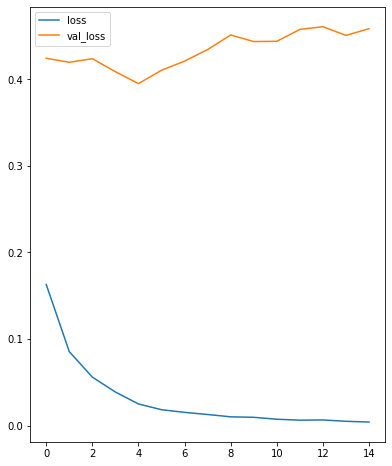

In [17]:
plt.figure(figsize = (14, 8))
plt.subplot(1,2,1)
plt.plot(new_history.history['loss'], label='loss')
plt.plot(new_history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')


plt.show()

# References

1. [A Guide to TensorFlow Callbacks](https://blog.paperspace.com/tensorflow-callbacks/)
2. [Writing your own callbacks](https://www.tensorflow.org/guide/keras/custom_callback)
3. [tf.keras.callbacks.Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)
4. [A Practical Introduction to Keras Callbacks in TensorFlow 2](https://towardsdatascience.com/a-practical-introduction-to-keras-callbacks-in-tensorflow-2-705d0c584966)
5. [How to use TensorFlow callbacks?](https://medium.com/ydata-ai/how-to-use-tensorflow-callbacks-f54f9bb6db25)
6. [Callbacks in Tensor Flow](https://sailajakarra.medium.com/callbacks-in-tensor-flow-f8e7f9996f5f)
7. [Keras Callbacks Explained In Three Minutes](https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html)
